In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from tqdm import tqdm

In [ ]:
# Define the connection parameters
host = 'localhost'
dbname = 'StarsGalaxiesQuasars'
user = 'postgres'
password = '121792'
port = '5432'

# Create the connection string
connection = f'postgresql://{user}:{password}@{host}:{port}/{dbname}'

# Create a connection engine using SQLAlchemy
engine = create_engine(connection)

In [3]:
# Write a SQL query to join the observation and classification tables
join_query = """
SELECT o.*, c.class
FROM observation o
JOIN classification c ON o.classid = c.classid;
"""

In [4]:
# Load the data into a Pandas DataFrame
database_df = pd.read_sql(join_query, engine)

In [5]:
# Check DataFrame
database_df.head()

,observationid,classid,objid,ra,dec,u,g,r,i,z,redshift,run,rerun,camcol,field,specobjid,plate,mjd,fiberid,class
0,1,1,1237650000000000000,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752.0,301,4,267,3.722360e+18,-8.96e-06,3306,54922,491,STAR
1,2,1,1237650000000000000,183.598370,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752.0,301,4,267,3.638140e+17,-5.49e-05,323,51615,541,STAR
2,3,2,1237650000000000000,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752.0,301,4,268,3.232740e+17,0.1231112,287,52023,513,GALAXY
3,4,1,1237650000000000000,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752.0,301,4,269,3.722370e+18,-0.000110616,3306,54922,510,STAR
4,5,1,1237650000000000000,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752.0,301,4,269,3.722370e+18,0.000590357,3306,54922,512,STAR


C:\Users\Ian O'Connor\AppData\Local\Temp\ipykernel_26532\2057781444.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=database_df, x='class', palette='viridis')


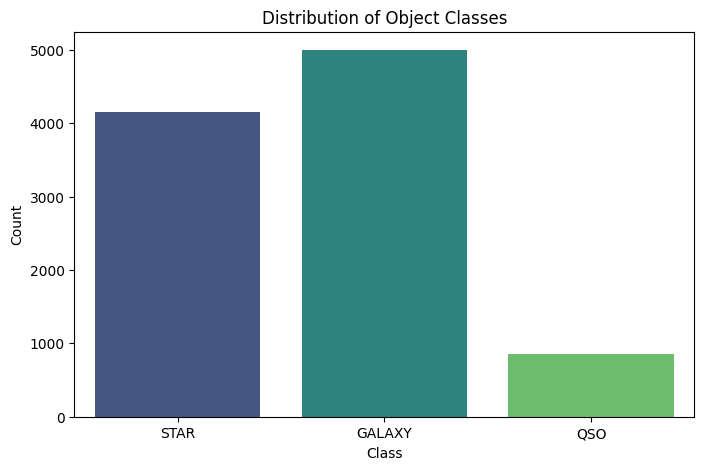

In [6]:
# Count plot of different classes
plt.figure(figsize=(8, 5))
sns.countplot(data=database_df, x='class', palette='viridis')
plt.title("Distribution of Object Classes")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()
# print(f"Class distribution:\n{y.value_counts()}")

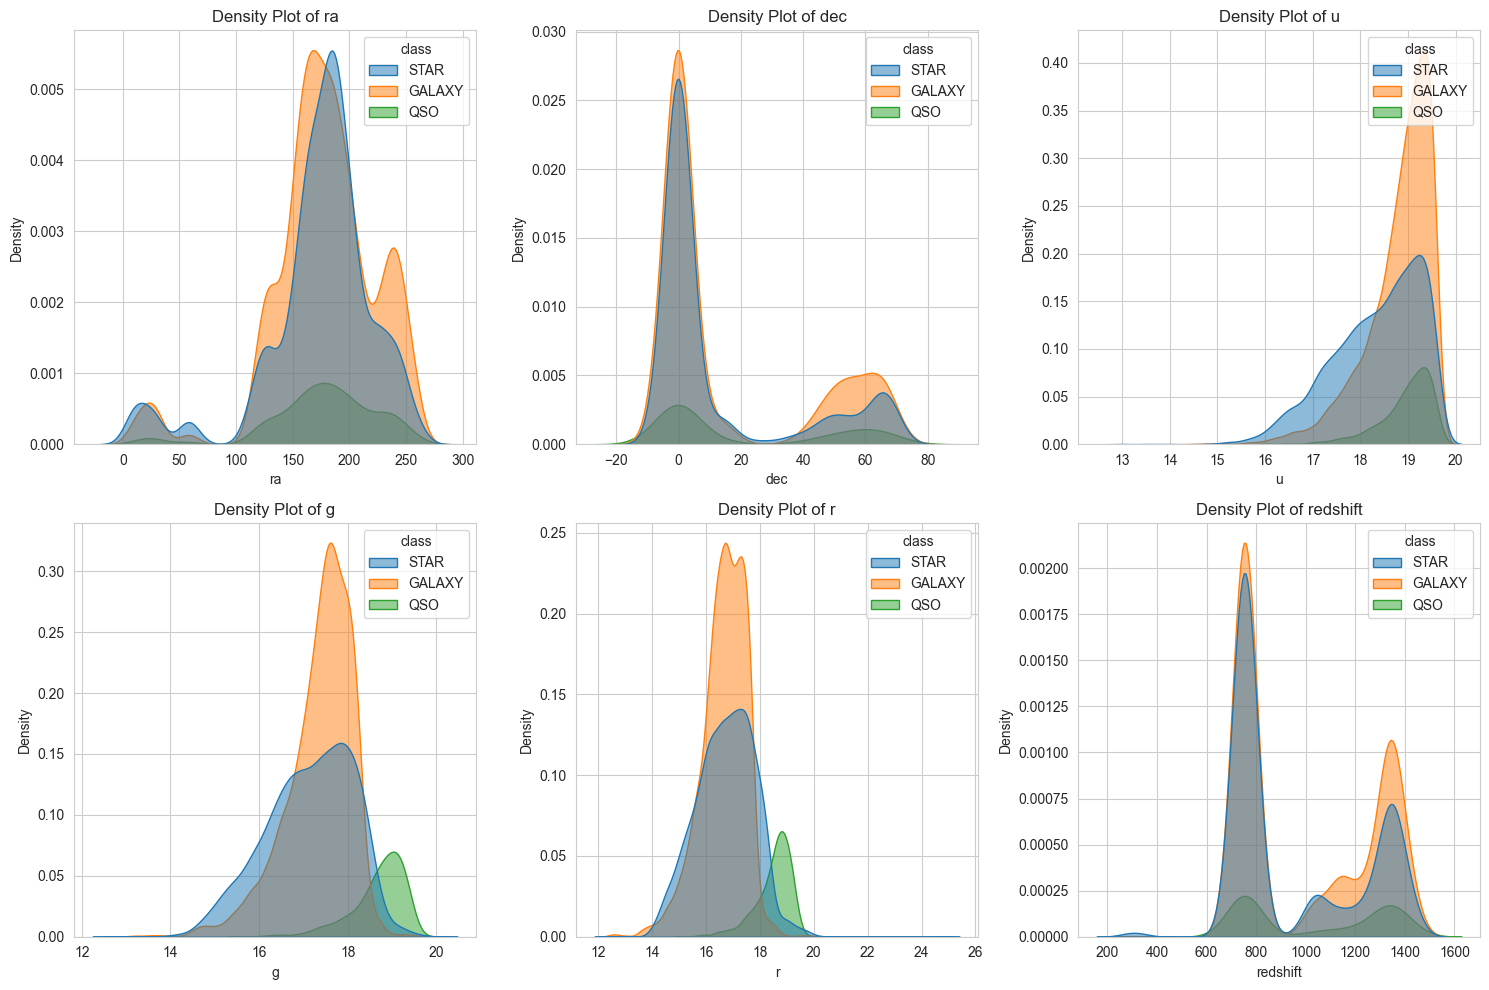

In [7]:
# Set plot style
sns.set_style("whitegrid")

# Density plots for numerical columns
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
features = ['ra', 'dec', 'u', 'g', 'r', 'redshift']
for i, feature in enumerate(features):
    row, col = divmod(i, 3)
    sns.kdeplot(data=database_df, x=feature, hue='class', fill=True, ax=axes[row, col], alpha=0.5)
    axes[row, col].set_title(f"Density Plot of {feature}")

plt.tight_layout()
plt.show()

In [ ]:
# 3D Scatter Plot of RA, DEC, and Redshift
fig = px.scatter_3d(database_df, x='ra', y='dec', z='redshift', color='class', opacity=0.7)
fig.update_layout(title="3D Scatter Plot of RA, DEC, and Redshift")
fig.show()

In [8]:
# Drop non-numeric columns except 'class'
ml = database_df.drop(columns=['observationid', 'classid', 'objid', 'specobjid', 'run', 'rerun', 'camcol', 'field', 'fiberid', 'plate', 'mjd', 'ra', 'dec', 'redshift'])

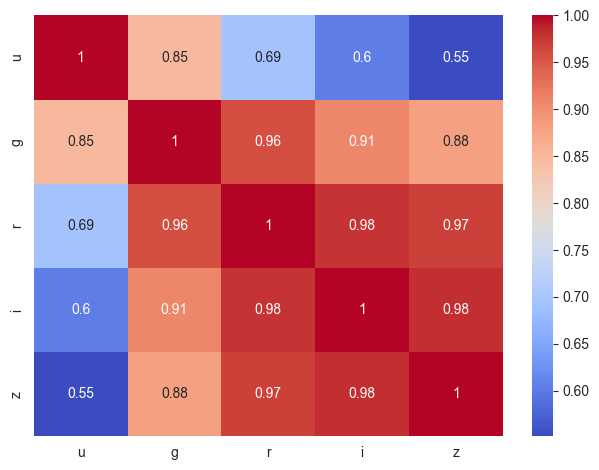

In [9]:
# Check for data leakage: Look for strong correlations between features and target class
# Select only the numeric columns for correlation analysis
numeric_df = ml.select_dtypes(include=[np.number])

# Compute the correlation matrix
corr_matrix = numeric_df.corr()

# Plot the heatmap
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.tight_layout()
plt.show()

In [10]:
# Encode categorical target variable
le = LabelEncoder()
ml['class'] = le.fit_transform(ml['class'])

In [11]:
# Separate the data into labels and features
y = database_df['class'].map({'STAR': 0, 'GALAXY': 1, 'QSO': 2})
X = ml.drop(columns=['class'])

In [12]:
# Split the data using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [13]:
# Initialize StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

In [14]:
# Train Random Forest Model
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, verbose=2)
rf.fit(X_train_scaled, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.0s


building tree 1 of 100building tree 2 of 100

building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished


RandomForestClassifier(n_jobs=-1, random_state=42, verbose=2)

In [15]:
# Predictions
y_pred_rf = rf.predict(X_test_scaled)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [16]:
# Evaluate model performance
print(f"Random Forest Model Accuracy: {accuracy_score(y_test, y_pred_rf):.2f}")
print(f"\nRandom Forest Model Report:\n{classification_report(y_test, y_pred_rf, target_names=['star', 'galaxy', 'qso'])}")

Random Forest Model Accuracy: 0.94

Random Forest Model Report:
              precision    recall  f1-score   support

        star       0.92      0.95      0.94       832
      galaxy       0.96      0.93      0.94       999
         qso       0.89      0.89      0.89       169

    accuracy                           0.94      2000
   macro avg       0.92      0.93      0.92      2000
weighted avg       0.94      0.94      0.94      2000



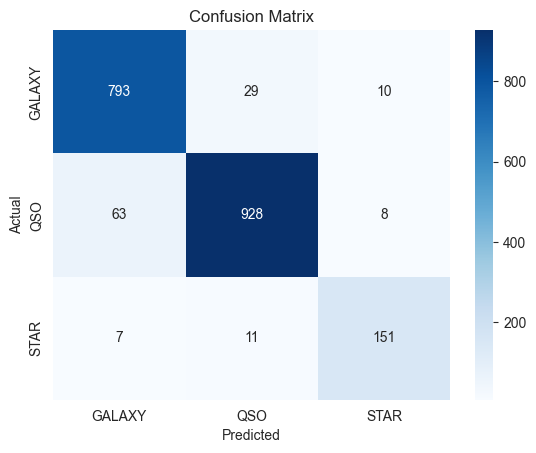

In [17]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

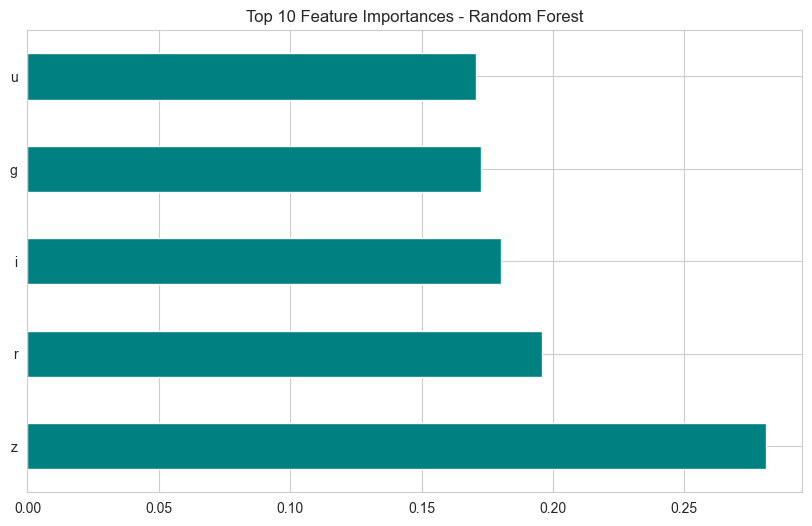

In [18]:
# Feature Importance Visualization
feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh', figsize=(10, 6), color='teal')
plt.title("Top 10 Feature Importances - Random Forest")
plt.show()

In [19]:
# Initialize and train the Gradient Boosting model
model = GradientBoostingClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

GradientBoostingClassifier(random_state=42)

In [20]:
# Make predictions
y_pred_gb = model.predict(X_test_scaled)

In [46]:
# Evaluate the model against the true class labels
print(f"Gradient Boosting Accuracy: {accuracy_score(y_test, y_pred_gb):.2f}")
print(classification_report(y_test, y_pred_gb, target_names=['star', 'galaxy', 'qso']))

Gradient Boosting Accuracy: 0.88
              precision    recall  f1-score   support

        star       0.84      0.90      0.87       832
      galaxy       0.92      0.87      0.89       999
         qso       0.90      0.85      0.87       169

    accuracy                           0.88      2000
   macro avg       0.89      0.87      0.88      2000
weighted avg       0.88      0.88      0.88      2000



In [ ]:
# Define hyperparameter tuning grid
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of boosting stages
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Step size shrinkage
    'max_depth': [3, 5, 7],  # Maximum depth of individual trees
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples required at a leaf node
    'subsample': [0.7, 0.8, 0.9, 1.0]  # Fraction of samples used for fitting individual trees
}

# Initialize the Gradient Boosting model
gb = GradientBoostingClassifier(random_state=42)

In [50]:
# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(gb, param_grid, n_iter=4, cv=3, scoring='accuracy', n_jobs=-1, verbose=1, random_state=634)

def fit_with_progress_bar(random_search, X_train, y_train):
    with tqdm(total=random_search.n_iter, desc="Progress", unit="trial") as pbar:
        best_score = -np.inf
        best_params = None
        
        params = random_search.param_distributions
        for _ in range(random_search.n_iter):
            random_params = {key: np.random.choice(val) if isinstance(val, list) else val for key, val in params.items()}
            gb.set_params(**random_params)
            
            cv = StratifiedKFold(n_splits=random_search.cv, shuffle=True, random_state=1)
            cv_scores = [gb.fit(X_train.iloc[train_idx], y_train.iloc[train_idx]).score(X_train.iloc[test_idx], y_train.iloc[test_idx]) for train_idx, test_idx in cv.split(X_train, y_train)]
            
            mean_score = np.mean(cv_scores)
            if mean_score > best_score:
                best_score = mean_score
                best_params = random_params
            
            pbar.update(1)
        
        return best_params, best_score

In [51]:
# Print best hyperparameters
best_params, best_score = fit_with_progress_bar(random_search, X_train_scaled, y_train)
print("\nBest SVM Parameters:", best_params)
print("\nBest Score:", best_score)

Progress: 100%|██████████| 4/4 [01:42<00:00, 25.64s/trial]


Best SVM Parameters: {'n_estimators': 300, 'learning_rate': 0.2, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 0.7}

Best Score: 0.9364995917145765


In [55]:
# Train final model using the best found hyperparameters
best_gb = GradientBoostingClassifier(**best_params, random_state=42)
best_gb.fit(X_train_scaled, y_train)

GradientBoostingClassifier(learning_rate=0.2, max_depth=7, n_estimators=300,
                           random_state=42, subsample=0.7)

In [56]:
# Make predictions
y_pred_best_gb = best_gb.predict(X_test_scaled)

In [57]:
# Evaluate the optimized model
print(f"Optimized Gradient Boosting Accuracy: {accuracy_score(y_test, y_pred_best_gb):.2f}")
print(classification_report(y_test, y_pred_best_gb, target_names=['star', 'galaxy', 'qso']))

Optimized Gradient Boosting Accuracy: 0.94
              precision    recall  f1-score   support

        star       0.92      0.96      0.94       832
      galaxy       0.96      0.93      0.95       999
         qso       0.91      0.90      0.90       169

    accuracy                           0.94      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.94      0.94      0.94      2000



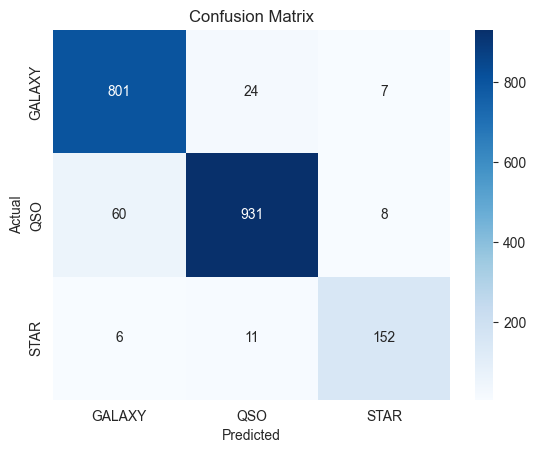

In [59]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_best_gb)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [23]:
# Instantiate the Logistic Regression model
# Assign a random_state parameter of 1 to the model
logistic_model = LogisticRegression(random_state=12, max_iter=100)

# Fit the model using scaled training data
logistic_model.fit(X_train_scaled, y_train)

LogisticRegression(random_state=12)

In [24]:
# Make a prediction using the testing data
y_pred_lr = logistic_model.predict(X_test_scaled)

In [25]:
# Print the classification report for the model
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"\nLogistic Regression Model Report:\n{classification_report(y_test, y_pred_lr, target_names=['star', 'galaxy', 'qso'])}")

Logistic Regression Accuracy: 0.9350

Logistic Regression Model Report:
              precision    recall  f1-score   support

        star       0.91      0.96      0.93       832
      galaxy       0.96      0.92      0.94       999
         qso       0.93      0.90      0.92       169

    accuracy                           0.94      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.94      0.94      0.94      2000



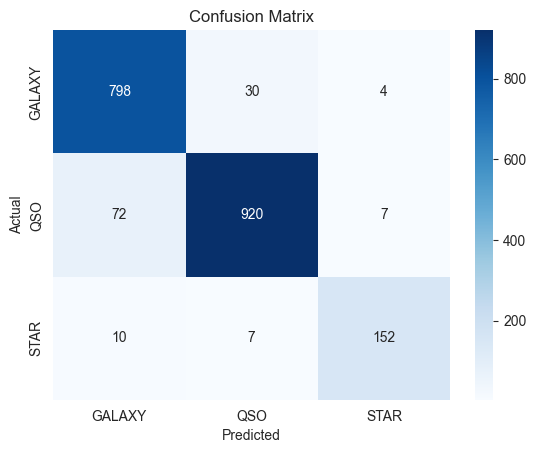

In [26]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [27]:
# Initialize the model
svm_model = SGDClassifier(loss='hinge', random_state=100, max_iter=1, tol=None)
n_epochs = 100

In [28]:
# Define class labels outside the loop
classes = np.unique(y)

print("\nTraining SVM with SGD:")
for epoch in tqdm(range(n_epochs), desc="Epoch Progress"):
    svm_model.partial_fit(X_train_scaled, y_train, classes=classes)


Training SVM with SGD:


Epoch Progress: 100%|██████████| 100/100 [00:00<00:00, 207.91it/s]


In [29]:
# Make predictions
y_pred_svm = svm_model.predict(X_test_scaled)

In [30]:
# Evaluate the SVM model
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm, target_names=['star', 'galaxy', 'qso']))

Accuracy: 0.9385

Classification Report:
               precision    recall  f1-score   support

        star       0.92      0.97      0.94       832
      galaxy       0.95      0.94      0.95       999
         qso       0.96      0.79      0.86       169

    accuracy                           0.94      2000
   macro avg       0.94      0.90      0.92      2000
weighted avg       0.94      0.94      0.94      2000



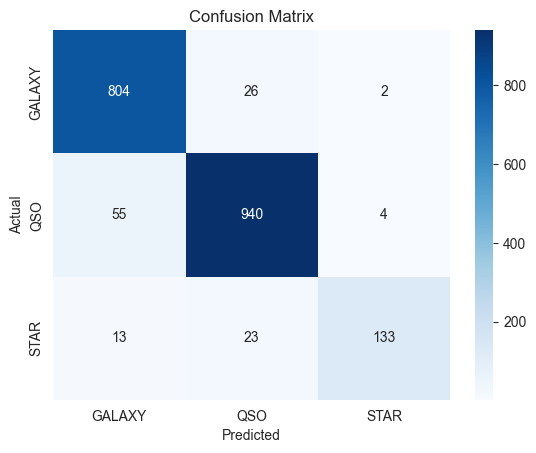

In [31]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [32]:
# Define the Hyperparameter Tuning grid for SVM
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf', 'poly']}
svc = SVC()

In [33]:
# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(svc, param_grid, n_iter=4, cv=3, scoring='accuracy', n_jobs=-1, verbose=1, random_state=634)

def fit_with_progress_bar(random_search, X_train, y_train):
    with tqdm(total=random_search.n_iter, desc="Progress", unit="trial") as pbar:
        best_score = -np.inf
        best_params = None
        
        params = random_search.param_distributions
        for _ in range(random_search.n_iter):
            random_params = {key: np.random.choice(val) if isinstance(val, list) else val for key, val in params.items()}
            svc.set_params(**random_params)
            
            cv = StratifiedKFold(n_splits=random_search.cv, shuffle=True, random_state=1)
            cv_scores = [svc.fit(X_train.iloc[train_idx], y_train.iloc[train_idx]).score(X_train.iloc[test_idx], y_train.iloc[test_idx]) for train_idx, test_idx in cv.split(X_train, y_train)]
            
            mean_score = np.mean(cv_scores)
            if mean_score > best_score:
                best_score = mean_score
                best_params = random_params
            
            pbar.update(1)
        
        return best_params, best_score

In [34]:
best_params, best_score = fit_with_progress_bar(random_search, X_train_scaled, y_train)
print("\nBest SVM Parameters:", best_params)
print("\nBest Score:", best_score)

Progress: 100%|██████████| 4/4 [00:07<00:00,  1.84s/trial]


Best SVM Parameters: {'C': 10.0, 'kernel': 'rbf'}

Best Score: 0.9558748892322443


In [35]:
# Train with linear kernel model
svm_linear = SVC(kernel='linear', random_state=42)
svm_linear.fit(X_train_scaled, y_train)

SVC(kernel='linear', random_state=42)

In [36]:
# Predictions
y_pred_svm_linear = svm_linear.predict(X_test_scaled)

In [37]:
# Evaluate the linear Kernel Model
print("Linear Kernel Classification Report:")
print(classification_report(y_test, y_pred_svm_linear, target_names=['star', 'galaxy', 'qso']))
print("Accuracy (linear Kernel):", accuracy_score(y_test, y_pred_svm))

Linear Kernel Classification Report:
              precision    recall  f1-score   support

        star       0.92      0.97      0.95       832
      galaxy       0.98      0.94      0.96       999
         qso       0.91      0.88      0.89       169

    accuracy                           0.95      2000
   macro avg       0.94      0.93      0.93      2000
weighted avg       0.95      0.95      0.95      2000

Accuracy (linear Kernel): 0.9385


In [43]:
# Train with rbf kernel model
svm_rbf = SVC(kernel='rbf', random_state=42)
svm_rbf.fit(X_train_scaled, y_train)

SVC(random_state=42)

In [44]:
# Predictions
y_pred_svm_rbf = svm_rbf.predict(X_test_scaled)

In [45]:
# Evaluate the linear Kernel Model
print("Linear Kernel Classification Report:")
print(classification_report(y_test, y_pred_svm_rbf, target_names=['star', 'galaxy', 'qso']))
print("Accuracy (linear Kernel):", accuracy_score(y_test, y_pred_svm))

Linear Kernel Classification Report:
              precision    recall  f1-score   support

        star       0.90      0.97      0.94       832
      galaxy       0.98      0.92      0.94       999
         qso       0.93      0.91      0.92       169

    accuracy                           0.94      2000
   macro avg       0.94      0.93      0.93      2000
weighted avg       0.94      0.94      0.94      2000

Accuracy (linear Kernel): 0.9385


In [42]:
# Use the best parameters from RandomizedSearchCV
best_svc = SVC(C=best_params['C'], kernel=best_params['kernel'], random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(best_svc, X_train_scaled, y_train, cv=StratifiedKFold(n_splits=5), n_jobs=-1)

print(f"Cross-validation scores: \n{cv_scores}")
print(f"\nMean cross-validation score: \n{cv_scores.mean():.4f}")

Cross-validation scores: 
[0.95375  0.955625 0.956875 0.955625 0.96375 ]

Mean cross-validation score: 
0.9571


In [39]:
# Apply PCA for visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [40]:
svm_model_pca = SGDClassifier(loss='hinge', max_iter=10000, tol=1e-3, verbose=1, random_state=100)
svm_model_pca.fit(X_train_pca, y_train)
y_pred_pca = svm_model_pca.predict(X_test_pca)

-- Epoch 1
Norm: 8.01, NNZs: 2, Bias: 2.114924, T: 8000, Avg. loss: 3.929585
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 4.89, NNZs: 2, Bias: 1.462426, T: 16000, Avg. loss: 1.628302
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 2.23, NNZs: 2, Bias: -0.728570, T: 24000, Avg. loss: 1.253217
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 1.12, NNZs: 2, Bias: -0.643289, T: 32000, Avg. loss: 1.080920
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 2.10, NNZs: 2, Bias: -0.590026, T: 40000, Avg. loss: 0.991662
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 2.44, NNZs: 2, Bias: -0.344371, T: 48000, Avg. loss: 0.932212
Total training time: 0.00 seconds.
-- Epoch 7
Norm: 1.29, NNZs: 2, Bias: -0.516494, T: 56000, Avg. loss: 0.910247
Total training time: 0.00 seconds.
-- Epoch 8
Norm: 1.86, NNZs: 2, Bias: -0.338096, T: 64000, Avg. loss: 0.880143
Total training time: 0.00 seconds.
-- Epoch 9
Norm: 1.11, NNZs: 2, Bias: -0.885222, T: 72000, Avg. loss: 0.848868
Total traini

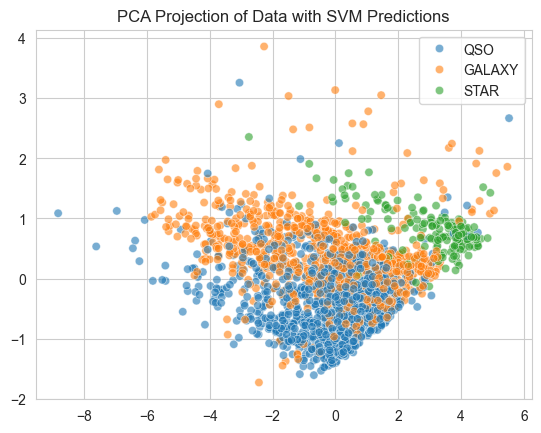

In [41]:
hue_labels = le.inverse_transform(y_test) if hasattr(le, "classes_") else y_test
sns.scatterplot(x=X_test_pca[:, 0], y=X_test_pca[:, 1], hue=hue_labels, alpha=0.6)
plt.title("PCA Projection of Data with SVM Predictions")
plt.show()